In [1]:
# importar librerias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sktime.performance_metrics.forecasting import MeanSquaredError, MeanAbsolutePercentageError, MeanAbsoluteScaledError, MeanSquaredScaledError
from math import sqrt, ceil

In [2]:
# Leer train y test
train = pd.read_csv('../Data/train.csv')
test = pd.read_csv('../Data/test.csv')

In [3]:
def media_movil(s, periodo):
    serie = s.copy()
    serie['media_movil'] = serie['udsVenta'].rolling(periodo).mean()
    serie['media_movil'] = serie['media_movil'].shift(1)
    serie = serie.dropna()
    serie['media_movil'] = serie['media_movil'].round(0)
    rmse = MeanSquaredError(square_root=True)
    error = rmse(serie['udsVenta'], serie['media_movil'])
    return error, serie

In [4]:
def entrenar_media_movil(serie, max_periodo):
    periodos = range(2, max_periodo)
    rmse = []
    for i in periodos:
        error, s = media_movil(serie, i)
        rmse.append(error)
    best_period = periodos[rmse.index(min(rmse))]
    return best_period

In [5]:
periodos_sku = []
for i in range(1, 51):
    train_sku = train[train['idSku'] == i]
    train_sku = train_sku[['idSecuencia', 'udsVenta', 'bolHoliday']]
    # if theres any 1 in bolHoliday
    if 1 in train_sku['bolHoliday']:
        train_sku = train_sku[train_sku['bolHoliday'] == False]
    best_period = entrenar_media_movil(train_sku, 30)
    periodos_sku.append(best_period)

C:\Users\96gar\AppData\Roaming\Python\Python38\site-packages\sktime\performance_metrics\forecasting\_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
C:\Users\96gar\AppData\Roaming\Python\Python38\site-packages\sktime\performance_metrics\forecasting\_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
C:\Users\96gar\AppData\Roaming\Python\Python38\site-packages\sktime\performance_metrics\forecasting\_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
C:\Users\96gar\AppData\Roaming\Python\Python38\site-packages\sktime\performance_metrics\forecasting\_classes.py:422: UserWar

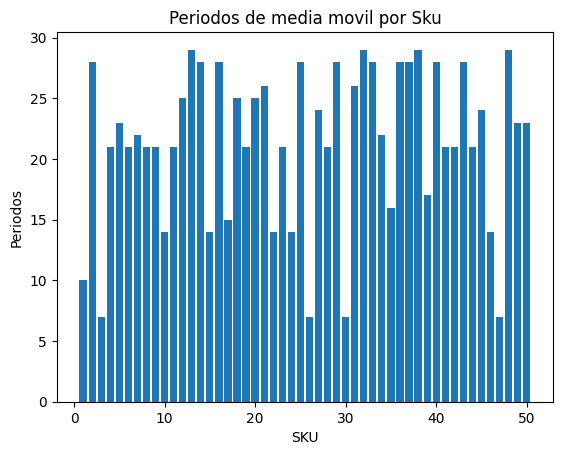

In [6]:
# barplot periodos
plt.bar(range(1, 51), periodos_sku)
plt.title('Periodos de media movil por Sku')
plt.xlabel('SKU')
plt.ylabel('Periodos')
plt.show()

In [7]:
# create dataframe with 3 columns, idSku, target and prediction
results = pd.DataFrame(columns=['idSku', 'target', 'prediction'])
for i in range(1, 51):
    # test
    train_sku = train[train['idSku'] == i]
    train_sku = train_sku[['idSecuencia', 'udsVenta', 'bolHoliday']]
    test_sku = test[test['idSku'] == i]
    test_sku = test_sku[['idSecuencia', 'udsVenta', 'bolHoliday']]
    # if theres any 1 in bolHoliday
    if 1 in test_sku['bolHoliday'].unique():
        x_test = test_sku[test_sku['bolHoliday'] == False]
        x_train = train_sku[train_sku['bolHoliday'] == False]
    else:
        x_test = test_sku
        x_train = train_sku
    # get best period for sku
    best_period = periodos_sku[i-1]
    # get the last values best periods values of train and add at the begining of test
    last_values = x_train.tail(best_period)
    last_values = last_values.append(x_test).reset_index(drop=True)

    error, s = media_movil(last_values, best_period)
    test_sku = test_sku.merge(s[['idSecuencia', 'media_movil']], on='idSecuencia', how='left')
    test_sku['media_movil'] = test_sku['media_movil'].fillna(0).astype(int)
    target = test_sku['udsVenta']
    prediction = test_sku['media_movil']
    results = results.append({'idSku': i, 'target': target, 'prediction': prediction}, ignore_index=True)

C:\Users\96gar\AppData\Local\Temp\ipykernel_23300\731372267.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_values = last_values.append(x_test).reset_index(drop=True)
C:\Users\96gar\AppData\Roaming\Python\Python38\site-packages\sktime\performance_metrics\forecasting\_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
C:\Users\96gar\AppData\Local\Temp\ipykernel_23300\731372267.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'idSku': i, 'target': target, 'prediction': prediction}, ignore_index=True)
C:\Users\96gar\AppData\Local\Temp\ipykernel_23300\731372267.py:20: FutureWarning: The frame.append method is deprecated and will be remove

In [8]:
# RMSE: Root Mean Squared Error
# MAPE: Mean Absolute Percentage Error
# MASE: Mean Absolute Scaled Error
# SMAPE: Symmetric Mean Absolute Percentage Error
# RMSSE: Root Mean Squared Scaled Error

results['RMSE'] = np.nan
results['MAPE'] = np.nan
results['MASE'] = np.nan
results['SMAPE'] = np.nan
results['RMSSE'] = np.nan

rmse = MeanSquaredError(square_root=True)
mape = MeanAbsolutePercentageError()
mase = MeanAbsoluteScaledError()
smape = MeanAbsolutePercentageError(symmetric=True)
rmsse = MeanSquaredScaledError(square_root=True)

# calculate rmse for each sku and append to results dataframe
for i in range(0, 50):
    t = results['target'][i]
    p = results['prediction'][i]
    y_train = train[train['idSku'] == i+1]['udsVenta']
    results['RMSE'][i] = rmse(t, p)
    results['MAPE'][i] = mape(t, p)
    results['MASE'][i] = mase(t, p, y_train=y_train)
    results['SMAPE'][i] = smape(t, p)
    results['RMSSE'][i] = rmsse(t, p, y_train=y_train)
results

C:\Users\96gar\AppData\Roaming\Python\Python38\site-packages\sktime\performance_metrics\forecasting\_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
C:\Users\96gar\AppData\Local\Temp\ipykernel_23300\3209599410.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['RMSE'][i] = rmse(t, p)
C:\Users\96gar\AppData\Roaming\Python\Python38\site-packages\sktime\performance_metrics\forecasting\_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
C:\Users\96gar\AppData\Local\Temp\ipykernel_23300\3209599410.py:25: SettingWithCopy

,idSku,target,prediction,RMSE,MAPE,MASE,SMAPE,RMSSE
0,1,0 0 1 27 2 9 3 0 4 ...,0 0 1 21 2 22 3 21 4 ...,8.662509,1.512928e+15,0.487332,0.363787,0.560724
1,2,0 0 1 21 2 6 3 12 4 ...,0 0 1 15 2 15 3 14 4 ...,8.294859,6.685031e+14,0.457018,0.426210,0.460470
2,3,0 0 1 12 2 9 3 3 4 ...,0 0 1 7 2 8 3 9 4 9 ...,11.122893,3.940650e+15,0.573420,0.558942,0.786399
3,4,0 0 1 0 2 9 3 6 4 ...,0 0 1 9 2 9 3 9 4 ...,6.318994,3.659175e+15,0.560257,0.540292,0.639214
4,5,0 0 1 0 2 0 3 0 4 ...,0 0 1 4 2 4 3 4 4 ...,7.651593,1.583297e+15,0.567562,0.622109,0.606207
5,6,0 0 1 9 2 6 3 3 4 ...,0 0 1 10 2 10 3 9 4 ...,7.213811,2.146247e+15,0.530340,0.491354,0.584796
6,7,0 0 1 6 2 15 3 9 4 ...,0 0 1 9 2 9 3 9 4 ...,5.125000,1.759219e+15,0.489403,0.451073,0.561816
7,8,0 0 1 6 2 6 3 6 4 6 ...,0 0 1 6 2 6 3 6 4 6 ...,5.626389,4.609153e+15,0.708117,0.641153,0.730110
8,9,0 0 1 3 2 0 3 21 4 ...,0 0 1 13 2 0 3 12 4 ...,7.784701,2.005509e+15,1.054813,0.671981,0.997324
9,10,0 0 1 21 2 9 3 12 4 ...,0 0 1 10 2 11 3 11 4 ...,5.176570,3.835097e+15,0.558030,0.763054,0.592674


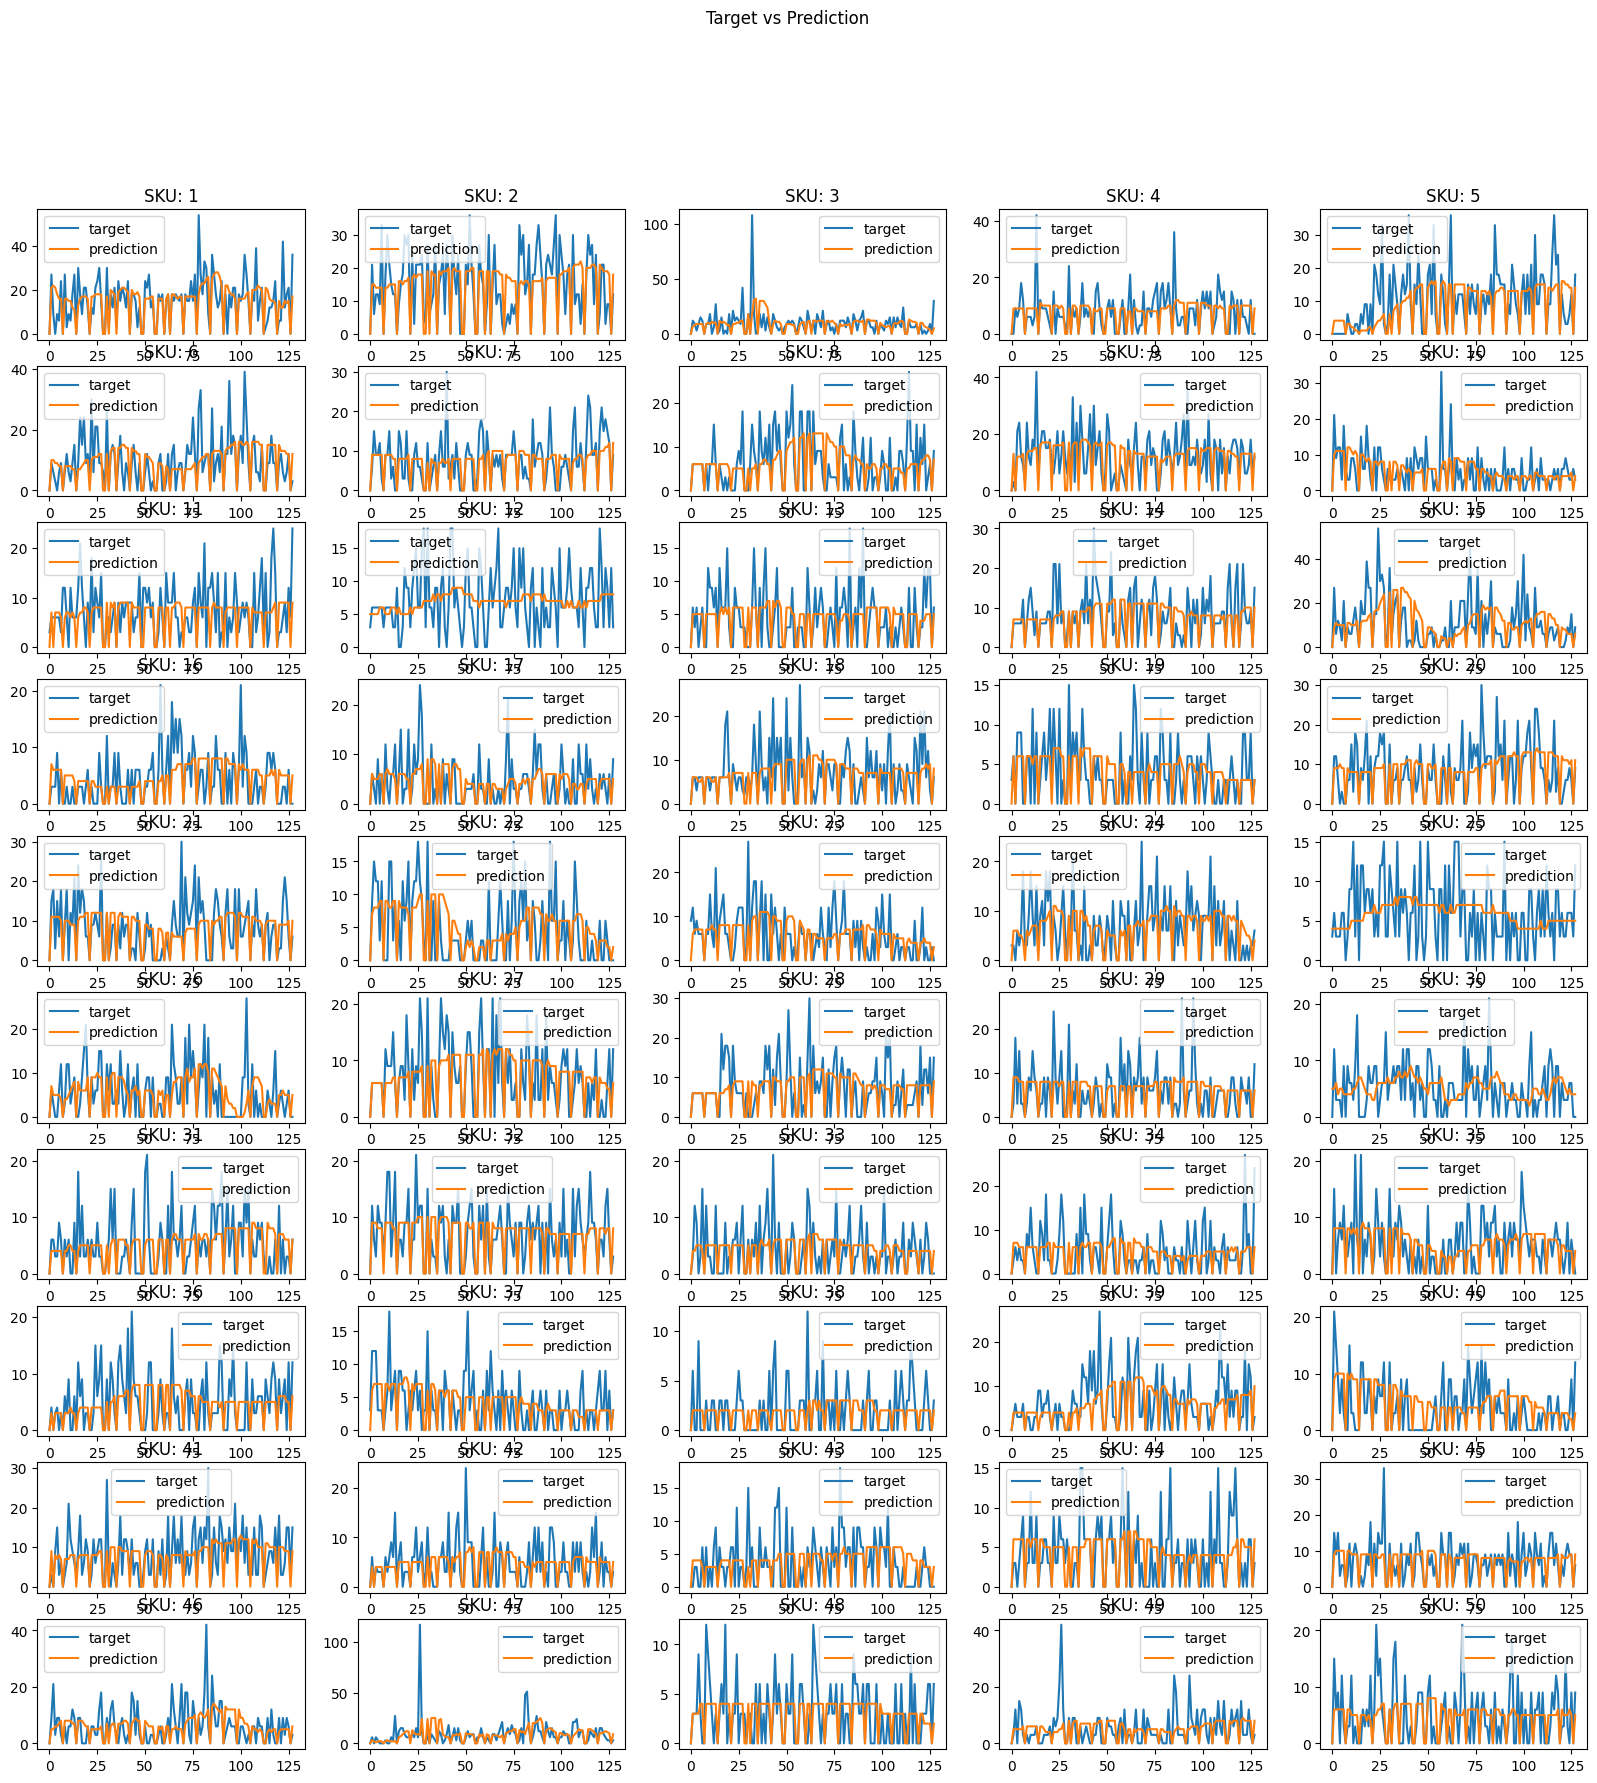

In [9]:
# make 50 subplots in a 10x5 grid and plot the target and prediction
fig, axs = plt.subplots(10, 5, figsize=(20, 20))
fig.suptitle('Target vs Prediction')
for i in range(10):
    for j in range(5):
        axs[i, j].plot(results['target'][i*5+j], label='target')
        axs[i, j].plot(results['prediction'][i*5+j], label='prediction')
        axs[i, j].legend()
        axs[i, j].set_title('SKU: ' + str(i*5+j+1))
plt.show()


In [10]:
# get the metrics of the results dataframe
metrics = results[['RMSE', 'MAPE', 'MASE', 'SMAPE', 'RMSSE']]

# get the mean of each metric
metrics_mean = metrics.mean()
metrics_mean

RMSE     5.532003e+00
MAPE     3.462142e+15
MASE     6.743515e-01
SMAPE    6.457065e-01
RMSSE    6.991116e-01
dtype: float64

In [11]:
# importar ../Data/DatosCicloAprovisionamiento.xlsx
df_ciclo = pd.read_excel('../Data/DatosCicloAprovisionamiento.xlsx')
df_ciclo = df_ciclo.sort_values(by=['sku']).reset_index(drop=True)
df_ciclo = df_ciclo.rename(columns={'sku': 'idSku'})
df_ciclo.head()

,idSku,diasEntrePedidos,diasLeadtime
0,1,18,2
1,2,28,4
2,3,28,2
3,4,14,2
4,5,14,4


In [12]:
df_precio = pd.read_excel('../Data/DatosPrecioMedio.xlsx')
df_precio = df_precio.rename(columns={'idSkuIta': 'idSku'})
df_precio = df_precio.sort_values(by=['idSku']).reset_index(drop=True)
df_precio.head()

,idSku,eurPrecioMedio
0,1,1.370002
1,2,1.370002
2,3,1.370002
3,4,1.370002
4,5,1.370002


In [13]:
df_ciclo = df_ciclo.merge(df_precio, on='idSku', how='inner')
df_ciclo = df_ciclo.merge(results[['idSku', 'RMSE']], on='idSku', how='inner')
df_ciclo.head()


,idSku,diasEntrePedidos,diasLeadtime,eurPrecioMedio,RMSE
0,1,18,2,1.370002,8.662509
1,2,28,4,1.370002,8.294859
2,3,28,2,1.370002,11.122893
3,4,14,2,1.370002,6.318994
4,5,14,4,1.370002,7.651593


In [14]:
factor = 1.64
df_ciclo['stock_seguridad'] = df_ciclo.apply(lambda x: ceil(factor * x['RMSE'] * sqrt(x['diasLeadtime'])), axis=1)
df_ciclo.head()

,idSku,diasEntrePedidos,diasLeadtime,eurPrecioMedio,RMSE,stock_seguridad
0,1,18,2,1.370002,8.662509,21
1,2,28,4,1.370002,8.294859,28
2,3,28,2,1.370002,11.122893,26
3,4,14,2,1.370002,6.318994,15
4,5,14,4,1.370002,7.651593,26


Stock de seguridad = Factor servicio *RMSE * raíz del ciclo de aprovisionamiento
Cliclo de aprovisionamiento = tiempo de espera = lead time

In [15]:
df_ciclo['coste_stock_diario'] = df_ciclo.apply(lambda x: 0.05 * x['eurPrecioMedio'] * x['stock_seguridad'], axis=1)
df_ciclo.head()

,idSku,diasEntrePedidos,diasLeadtime,eurPrecioMedio,RMSE,stock_seguridad,coste_stock_diario
0,1,18,2,1.370002,8.662509,21,1.438502
1,2,28,4,1.370002,8.294859,28,1.918002
2,3,28,2,1.370002,11.122893,26,1.781002
3,4,14,2,1.370002,6.318994,15,1.027501
4,5,14,4,1.370002,7.651593,26,1.781002


In [16]:
coste_stock_diario_total = df_ciclo['coste_stock_diario'].sum().round(2)
coste_stock_diario_anual = coste_stock_diario_total * 365

print('Coste stock total diario: {}€'.format(coste_stock_diario_total))
print('Coste stock total anual: {}€'.format(coste_stock_diario_anual))

Coste stock total diario: 234.28€
Coste stock total anual: 85512.2€
